## Training ML models

Once you have explored the repository and selected an appropriate training dataset, you can stage it and train a model. In this notebook we will show an example of how to do so using the [EuroSAT](https://www.eotdl.com/datasets/EuroSAT-RGB) dataset, in its RGB version.

> Remember that you can run this notebook in your cloud workspace to train a model in the cloud. If you require a GPU-powered machine, let us know though Discord and we will provide one!

In [1]:
from eotdl.datasets import stage_dataset

path = stage_dataset("EuroSAT-RGB", version=1, path="data", force=True, assets=True)
path

Staging assets: 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


'data/EuroSAT-RGB'

In [ ]:
!unzip -q {path}/EuroSAT-RGB.zip -d data/train

> This might take a few minutes!

In order to streamline the training process, we will use the [PytorchEO](https://github.com/earthpulse/pytorchEO) library. This open source library is built on top of [Pytorch](https://pytorch.org/) and [Pytorch Lightning](https://lightning.ai/) to facilitate the design, implementation, training and deployment of deep learning models for Earth Observation. It offers AI-Ready EO datasets as well as ready-to-use tasks and models.

We can use the EuroSATRGB wrapper to pre-process the dataset, including the generation of classes, train/val/test splitting, etc. We plan to implement more wrappers for other datasets in the future, but feel free to contribute with your own (either to PytorchEO or any other library).

In [4]:
from pytorch_eo.datasets import EuroSATRGB

# do not set download to True since it will download the dataset from the original source and not EOTDL !

ds = EuroSATRGB(batch_size=25, verbose=True, path="data", download=False, data_folder='train/EuroSAT-RGB') 

ds.setup()

Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


In [6]:
ds.df

,image,label
0,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
1,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
2,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
3,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_2...,0
4,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
...,...,...
26995,data/train/EuroSAT-RGB/SeaLake/SeaLake_612.jpg,9
26996,data/train/EuroSAT-RGB/SeaLake/SeaLake_2863.jpg,9
26997,data/train/EuroSAT-RGB/SeaLake/SeaLake_606.jpg,9
26998,data/train/EuroSAT-RGB/SeaLake/SeaLake_2877.jpg,9


This dataset contains 27000 Sentinel 2 images classified in 10 categories. 

In [7]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

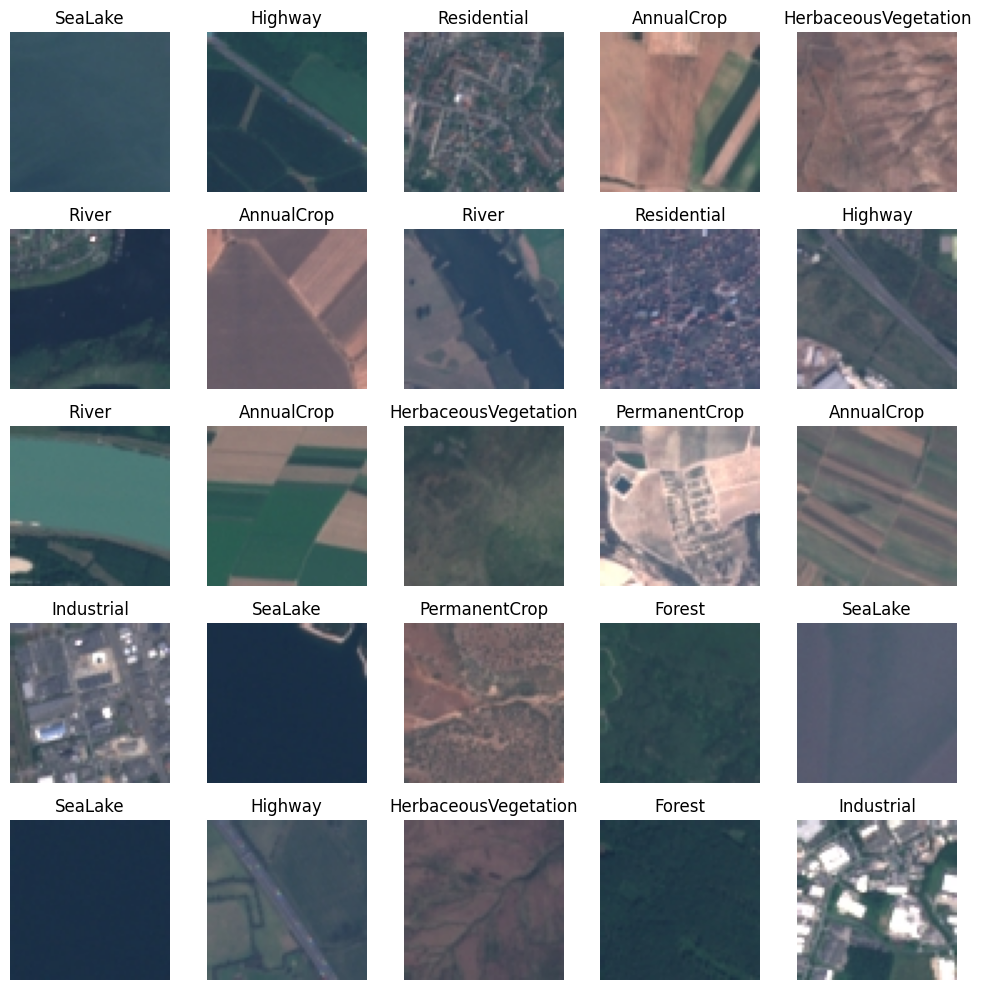

In [8]:
import matplotlib.pyplot as plt

batch = next(iter(ds.train_dataloader()))
imgs, labels = batch['image'], batch['label']

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

We will train a neural network for the task of Image classification.

In [9]:
import torch 
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

sample_inputs = torch.randn(8, 3, 224, 224)
output = task(sample_inputs)
output.shape

torch.Size([8, 10])

In [10]:
import lightning as L

device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

trainer = L.Trainer(
    accelerator=device,
    devices=1,
    max_epochs=5,
	enable_checkpointing=False,
	limit_train_batches=50,
	limit_val_batches=50,
)

trainer.fit(task, ds)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | ResNet             | 11.2 M | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc     | MulticlassAccuracy | 0      | train
-------------------------------------------------------
11.2 M    Trainable params


Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Once the model is trained you can evaluate it using some test data.

In [11]:
from tqdm import tqdm 

task.eval()
acc = 0
with torch.no_grad():
	for batch in tqdm(ds.test_dataloader()):
		output = task(batch['image'])
		acc += (output.argmax(1) == batch['label']).sum().item()

print("test accuracy: ", f'{acc}/{len(ds.test_dataloader().dataset)}')

100%|██████████| 216/216 [00:25<00:00,  8.54it/s]

test accuracy:  2870/5400


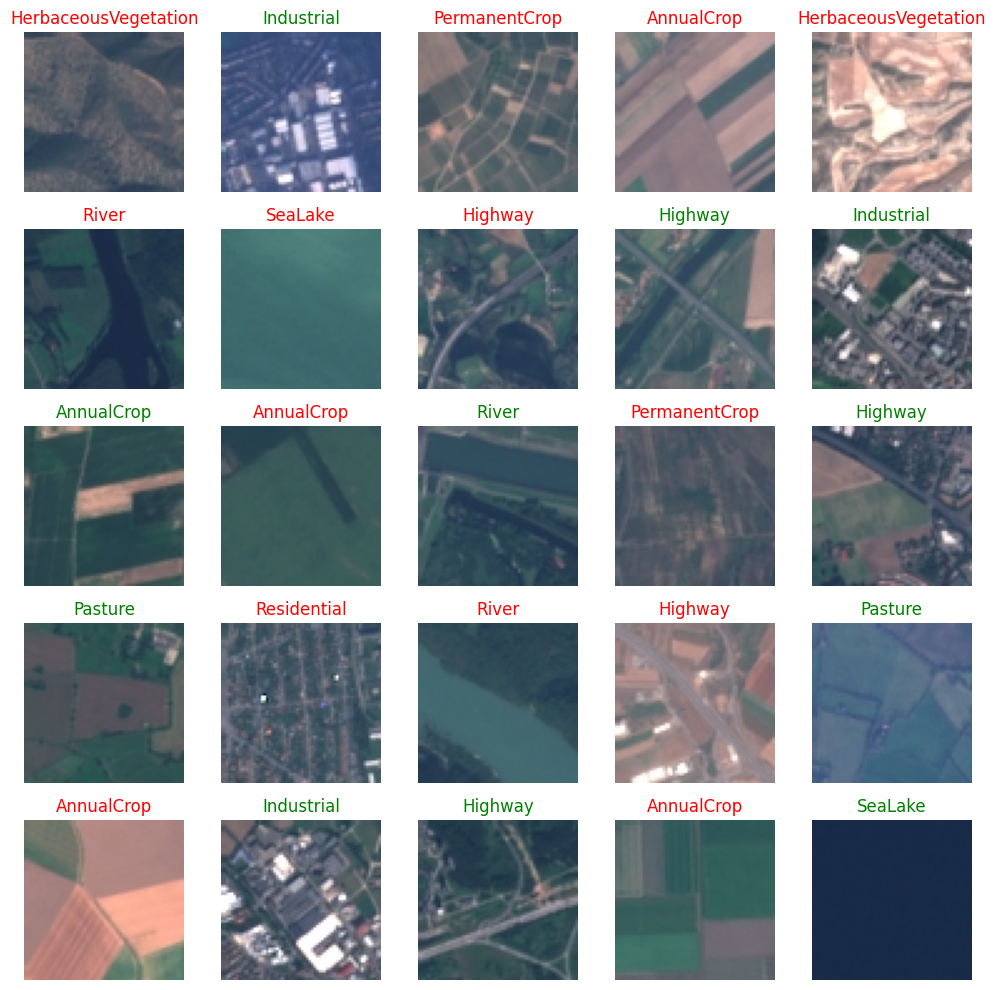

In [12]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch['image'], batch['label']

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()

And export it to later ingestion to the EOTDL. You can choose your preferred export method, here we use [ONNX]().

In [14]:
# !pip install onnx onnxruntime

In [13]:
import os

filepath = "outputs/model.onnx"
os.makedirs(os.path.dirname(filepath), exist_ok=True)

task.to_onnx(filepath, imgs, export_params=True, dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}})

/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:1863: UserWarning: Provided key input for dynamic axes is not a valid input/output name
  warnings.warn(
/Users/juan/Desktop/eotdl/.venv/lib/python3.12/site-packages/torch/onnx/utils.py:1863: UserWarning: Provided key output for dynamic axes is not a valid input/output name
  warnings.warn(


In [14]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: imgs.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(25, 10)

In [15]:
acc = 0
for batch in tqdm(ds.test_dataloader()):
	ort_inputs = {input_name: batch['image'].numpy()}
	ort_outs = ort_session.run(None, ort_inputs)
	acc += np.sum((ort_outs[0].argmax(1) == batch['label'].numpy()))

print("test accuracy: ", f'{acc}/{len(ds.test_dataloader().dataset)}')

100%|██████████| 216/216 [00:08<00:00, 25.40it/s]

test accuracy:  2870/5400


You will learn how to ingest this model to EOTDL in the nex notebook.

This has been a fast and easy example on how to train an ML model with a datasets downloaded from EOTDL. It is not our goal to provide a complete tutorial on how to train a model, but rather to show how to use the EOTDL. If you want to learn more about AI and training deep neural networks, we encourage you to explore the [PytorchEO](https://github.com/earthpulse/pytorchEO) library, and even contribute with more datasets, tasks, models and wrappers. We challenge you to train a better model!

## Discussion and Contribution opportunities

Feel free to ask questions now (live or through Discord) and make suggestions for future improvements.

- What would you like to see in the EOTDL concerning training? 
- What are the main challenges you face when training ML models with EO data? 
- What are the main datasets you would like to see in the EOTDL? 
- What are the main tasks you would like to see implemented? 
- What are the main models you would like to see implemented? 
- What are the frameworks you would like to have wrappers for?